# SPE GCS ML Challenge 2021
By: Doa Ibu Team
- Raden Sasangka Ardi Nugraha 
- Mordekhai
- Luthi Nurul Hidayah Saifudin
- Alfian Rahman

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import zipfile
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

## Exploratory Data Analysis

In [2]:
## Simple EDA 

## Data Preprocessing

In [3]:
## Code from Kak Upi (for train data)

In [4]:
## Code from Bang Dekha & Kak Upi (for test data)

In [5]:
df = pd.read_csv('data/preprocessed/train.csv')

## Data Cleansing

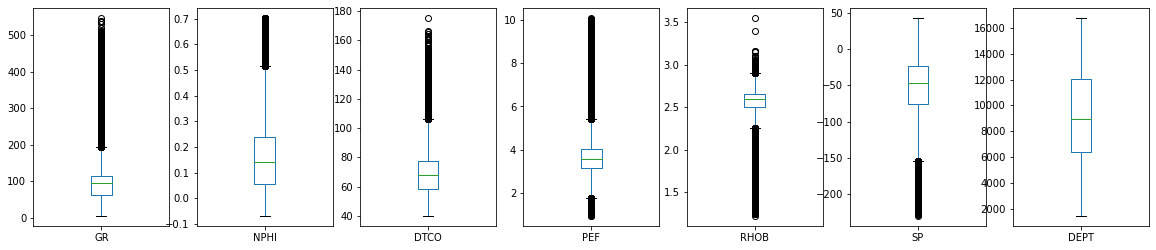

In [6]:
features = ['GR', 'NPHI', 'DTCO', 'PEF', 'RHOB', 'SP', 'DEPT']

def plot_features_box_plot(df=df, features=features):
    plt.figure(figsize=(20, 4))

    for idx, feature in enumerate(features):   
        plt.subplot(1, len(features), idx+1)
        df[feature].plot.box()
    plt.show()

plot_features_box_plot()

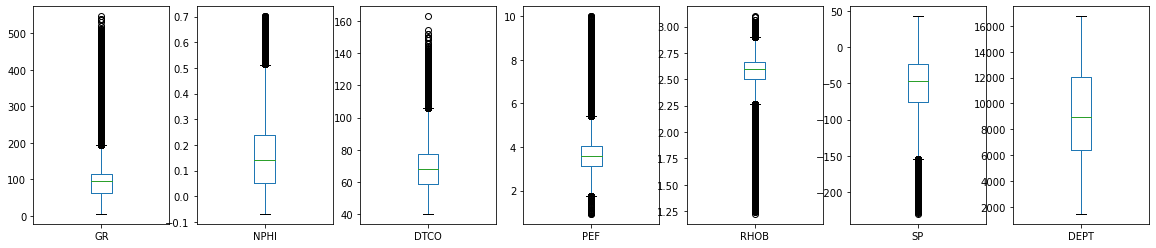

In [7]:
df = df.loc[
    (df['GR'] < 550) & 
    (df['DTCO'] < 170) & 
    (df['CAL'] >= 6) & (df['CAL'] <= 21) & 
    (df['PEF'] <= 10) &
    (df['RHOB'] <= 3.1) & 
    (df['SP'] <= 150), :]
df = df[df['DTCO'] < df['DTSM']]
plot_features_box_plot(df)

## Split Train & Test Data

In [8]:
X = df[features]
y = df['DTSM']

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

print('Total shape: ', df.shape)
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Total shape:  (173880, 12)
Train shape:  (139104, 7)
Test shape:  (34776, 7)


## Model Building (XGBoost)

In [9]:
def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

### Model All

In [10]:
model = XGBRegressor()
model.fit(X_train, y_train)

# Train performance
pred_train = model.predict(X_train)
print('RMSE train: ', rmse(y_train, pred_train))

# Test performance 
pred_test = model.predict(X_test)
print('RMSE test:', rmse(y_test, pred_test))

RMSE train:  7.539097411806665
RMSE test: 8.333483518220477


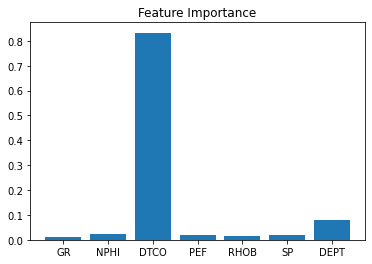

In [11]:
plt.bar(features, model.feature_importances_)
plt.title('Feature Importance')
plt.show()

### Model No PEF

In [12]:
# Split data 
X_no_pef = X.drop(columns='PEF')
X_train_no_pef, X_test_no_pef, _, _ = train_test_split(X_no_pef, y, test_size=0.2, random_state=9)

In [13]:
model_no_pef = XGBRegressor()
model_no_pef.fit(X_train_no_pef, y_train)

# Train performance
pred_train = model_no_pef.predict(X_train_no_pef)
print('RMSE train: ', rmse(y_train, pred_train))

# Test performance 
pred_test = model_no_pef.predict(X_test_no_pef)
print('RMSE test:', rmse(y_test, pred_test))

RMSE train:  7.718563099561678
RMSE test: 8.47888907316125


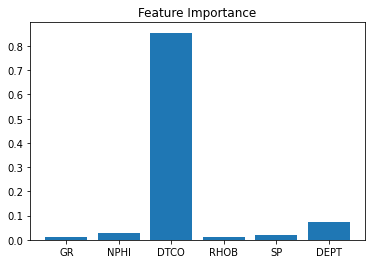

In [14]:
plt.bar([feature for feature in features if feature != 'PEF'], model_no_pef.feature_importances_)
plt.title('Feature Importance')
plt.show()

### Model No SP

In [15]:
# Split data 
X_no_sp = X.drop(columns='SP')
X_train_no_sp, X_test_no_sp, _, _ = train_test_split(X_no_sp, y, test_size=0.2, random_state=9)

In [16]:
model_no_sp = XGBRegressor()
model_no_sp.fit(X_train_no_sp, y_train)

# Train performance
pred_train_no_sp = model_no_sp.predict(X_train_no_sp)
print('RMSE train: ', rmse(y_train, pred_train_no_sp))

# Test performance 
pred_test_no_sp = model_no_sp.predict(X_test_no_sp)
print('RMSE test:', rmse(y_test, pred_test_no_sp))

RMSE train:  7.990412059613872
RMSE test: 8.804390255716322


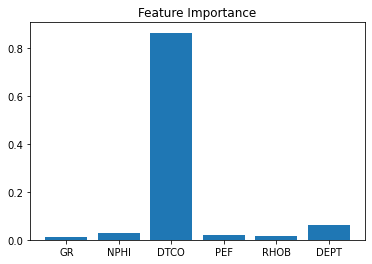

In [17]:
plt.bar([feature for feature in features if feature != 'SP'], model_no_sp.feature_importances_)
plt.title('Feature Importance')
plt.show()

### Model No SP & PEF

In [18]:
# Split data 
X_no_sp_pef = X.drop(columns=['SP', 'PEF'])
X_train_no_sp_pef, X_test_no_sp_pef, _, _ = train_test_split(X_no_sp_pef, y, test_size=0.2, random_state=9)

In [19]:
model_no_sp_pef = XGBRegressor()
model_no_sp_pef.fit(X_train_no_sp_pef, y_train)

# Train performance
pred_train_no_sp_pef = model_no_sp_pef.predict(X_train_no_sp_pef)
print('RMSE train: ', rmse(y_train, pred_train_no_sp_pef))

# Test performance 
pred_test_no_sp_pef = model_no_sp_pef.predict(X_test_no_sp_pef)
print('RMSE test:', rmse(y_test, pred_test_no_sp_pef))

RMSE train:  8.298783496357233
RMSE test: 9.0421988835626


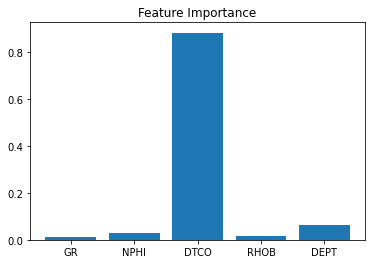

In [20]:
plt.bar([feature for feature in features if feature not in ['SP', 'PEF']], model_no_sp_pef.feature_importances_)
plt.title('Feature Importance')
plt.show()

## Prediction

In [21]:
df_test = pd.read_csv('data/preprocessed/test.csv', index_col=0)
df_test

,WELL,DEPT,CAL,SP,GR,NPHI,DRES,DTCO,PEF,RHOB,DRHO
0,00d02be79f49_TGS.las,9912.0,6.2363,12.2620,49.1883,0.4860,1900.9751,NaN,NaN,1.8771,-0.2491
1,00d02be79f49_TGS.las,9912.5,6.2481,5.1245,56.5820,0.4769,1990.3184,NaN,NaN,1.8989,-0.2487
2,00d02be79f49_TGS.las,9913.0,6.2844,-4.5998,68.5213,0.4480,1988.7848,NaN,NaN,2.0063,-0.2482
3,00d02be79f49_TGS.las,9913.5,6.6677,-14.8317,78.8782,0.3845,1987.2515,NaN,NaN,2.0603,-0.2478
4,00d02be79f49_TGS.las,9914.0,7.2943,-17.6811,83.4741,0.3215,1985.7203,NaN,NaN,2.1871,-0.2474
...,...,...,...,...,...,...,...,...,...,...,...
148001,ff7845ea074d_TGS.las,8817.0,7.7050,NaN,198.2077,0.0100,NaN,51.0738,2.4312,2.6322,0.0539
148002,ff7845ea074d_TGS.las,8817.5,7.5904,NaN,198.2105,0.0105,NaN,51.6112,2.4303,2.6145,0.0715
148003,ff7845ea074d_TGS.las,8818.0,7.4601,NaN,198.2134,0.0108,NaN,51.9350,2.3676,2.5828,0.0916
148004,ff7845ea074d_TGS.las,8818.5,7.3454,NaN,198.2162,0.0108,NaN,52.1779,2.2730,2.5610,0.1103


In [22]:
model_all_test_wells = ['2f96a5f92418_TGS', '34a80ab7a5fa_TGS', '1684cc35f399_TGS', '7595ba9fb314_TGS', 
                        '63250f7d463b_TGS', '113412eec2a6_TGS', '302460e3021a_TGS', '20372701d5e2_TGS', 
                        'ed48bda2217f_TGS', 'eed1e9537976_TGS', 'fca03aa6acde_TGS', 'ff7845ea074d_TGS']
model_no_pef_test_wells = ['00d02be79f49_TGS', '84c5fb9cc880_TGS']
model_no_sp_test_wells = ['0a7822c59487_TGS', '8e37531ba266_TGS', '94c1f5cae85c_TGS', '638f2cc65681_TGS', '3369b6f8fb6f_TGS']
model_no_sp_pef_test_wells = ['ae16a9f64878_TGS']

model_test_wells = {
    model: {
        'features': list(X_train.columns), 
        'wells': model_all_test_wells
    }, 
    model_no_pef: {
        'features': list(X_train_no_pef.columns), 
        'wells': model_no_pef_test_wells
    },
    model_no_sp: {
        'features': list(X_train_no_sp.columns), 
        'wells': model_no_sp_test_wells
    },
    model_no_sp_pef: {
        'features': list(X_train_no_sp_pef.columns), 
        'wells': model_no_sp_pef_test_wells
    }
}

In [23]:
for model_test, test_wells in model_test_wells.items():
    test_well_features = test_wells['features']
    for test_well in test_wells['wells']:
        well_code = test_well + '.las'
        model_test_pred = model_test.predict(df_test.loc[df_test['WELL'] == well_code, test_well_features])
        df_test.loc[df_test['WELL'] == well_code, 'DTSM_PRED'] = model_test_pred

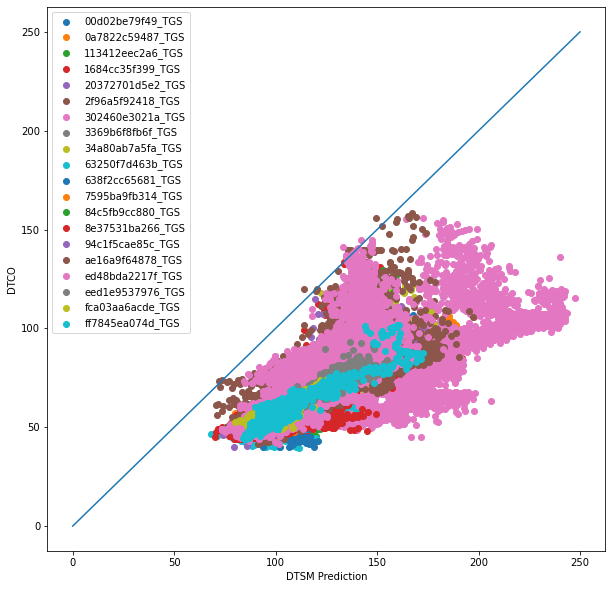

In [24]:
plt.figure(figsize=(10, 10))
for well in df_test['WELL'].unique():
    plt.scatter(df_test.loc[df_test['WELL'] == well, 'DTSM_PRED'], 
                df_test.loc[df_test['WELL'] == well, 'DTCO'], label=well[:-4])
plt.plot(np.linspace(0,250,11), np.linspace(0,250,11))
plt.xlabel('DTSM Prediction')
plt.ylabel('DTCO')
plt.legend()
plt.show()

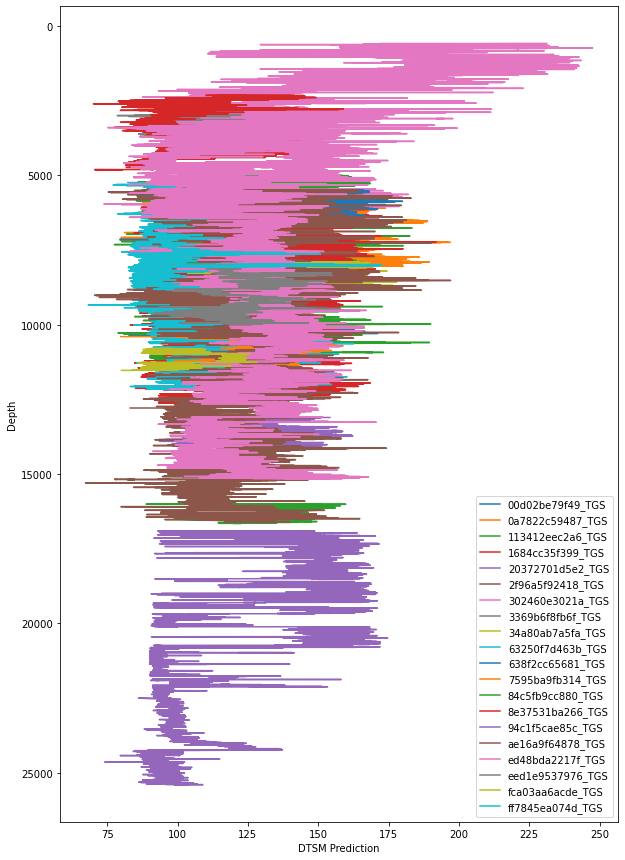

In [25]:
plt.figure(figsize=(10, 15))
for well in df_test['WELL'].unique():
    plt.plot(df_test.loc[df_test['WELL'] == well, 'DTSM_PRED'], 
                df_test.loc[df_test['WELL'] == well, 'DEPT'], label=well[:-4])
plt.xlabel('DTSM Prediction')
plt.ylabel('Depth')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## Submission

In [26]:
# Export prediction outputs to Excel files
for well in df_test['WELL'].unique():
    submission = df_test.loc[df_test['WELL'] == well, ['DEPT', 'DTSM_PRED']]
    submission.columns = ['Depth', 'DTSM']
    submission.to_excel('submission/' + well[:-4] + '.xlsx', index=False)

In [27]:
# Compress to zip 
with zipfile.ZipFile('submission/DoaIbu.zip', 'w') as zipF:
    for file in os.listdir('submission'):
        if file.endswith('.xlsx'):
            zipF.write(os.getcwd() + '/submission/' + file, file)